In [70]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [71]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [73]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 460, Edges: 4480

 Node types:
  default: [460]
    Features: float32 vector, length 650
    Edge types: default-default->default

 Edge types:
    default-default->default: [4480]
        Weights: range=[0.700023, 1], mean=0.804907, std=0.0987777
        Features: none


In [130]:
# Splitting data into train/validation/test

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

series_classes = df_classes['class']
series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  321
Len validation:  69
Len test:  70

Len everything:  460


In [75]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'stage1': 153,
         'stage2': 26,
         'stage4': 38,
         'control': 50,
         'stage3': 54})

In [10]:
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))

array(['control', 'stage1', 'stage2', 'stage3', 'stage4'], dtype='<U7')

In [131]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.284     , 0.41960784, 2.46923077, 1.18888889, 1.68947368])

## The cell below is used to downsample the training data. Skip it if this is not the goal

In [103]:
# Testar downsample na train_subjects
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)

Counter({'stage1': 50,
         'stage2': 26,
         'stage3': 50,
         'stage4': 38,
         'control': 50})

In [132]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [133]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [194]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

nb_classes = 5
input_dim = df_features.loc[train_subjects.index].values.shape[1]

model = Sequential()
model.add(Dense(128, input_dim=input_dim))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=["acc", metrics.AUC(curve="ROC")])

X_train = df_features.loc[train_subjects.index].values
y_train = train_targets

X_val = df_features.loc[val_subjects.index].values
y_val = val_targets

print("Training...")
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=8, verbose=2)

Training...
Epoch 1/500
41/41 - 1s - loss: 3.5744 - acc: 0.3832 - auc_6: 0.6651 - val_loss: 1.5189 - val_acc: 0.5507 - val_auc_6: 0.8289
Epoch 2/500
41/41 - 0s - loss: 2.3307 - acc: 0.4984 - auc_6: 0.7543 - val_loss: 1.4263 - val_acc: 0.6087 - val_auc_6: 0.8477
Epoch 3/500
41/41 - 0s - loss: 1.7593 - acc: 0.4984 - auc_6: 0.7856 - val_loss: 1.3715 - val_acc: 0.6377 - val_auc_6: 0.8465
Epoch 4/500
41/41 - 0s - loss: 1.5901 - acc: 0.5670 - auc_6: 0.8191 - val_loss: 1.2174 - val_acc: 0.5942 - val_auc_6: 0.8391
Epoch 5/500
41/41 - 0s - loss: 1.2797 - acc: 0.6012 - auc_6: 0.8451 - val_loss: 1.2640 - val_acc: 0.6087 - val_auc_6: 0.8451
Epoch 6/500
41/41 - 0s - loss: 1.2185 - acc: 0.6044 - auc_6: 0.8570 - val_loss: 1.2648 - val_acc: 0.6087 - val_auc_6: 0.8533
Epoch 7/500
41/41 - 0s - loss: 1.1049 - acc: 0.6636 - auc_6: 0.8750 - val_loss: 1.2359 - val_acc: 0.5652 - val_auc_6: 0.8393
Epoch 8/500
41/41 - 0s - loss: 1.0673 - acc: 0.6137 - auc_6: 0.8761 - val_loss: 1.2060 - val_acc: 0.6232 - val_au

Epoch 66/500
41/41 - 0s - loss: 0.1126 - acc: 0.9720 - auc_6: 0.9989 - val_loss: 1.4737 - val_acc: 0.6087 - val_auc_6: 0.8656
Epoch 67/500
41/41 - 0s - loss: 0.1071 - acc: 0.9595 - auc_6: 0.9988 - val_loss: 1.4617 - val_acc: 0.6232 - val_auc_6: 0.8807
Epoch 68/500
41/41 - 0s - loss: 0.0730 - acc: 0.9875 - auc_6: 0.9998 - val_loss: 1.5674 - val_acc: 0.5797 - val_auc_6: 0.8655
Epoch 69/500
41/41 - 0s - loss: 0.0841 - acc: 0.9844 - auc_6: 0.9994 - val_loss: 1.5099 - val_acc: 0.6232 - val_auc_6: 0.8737
Epoch 70/500
41/41 - 0s - loss: 0.0839 - acc: 0.9875 - auc_6: 0.9996 - val_loss: 1.4393 - val_acc: 0.5942 - val_auc_6: 0.8663
Epoch 71/500
41/41 - 0s - loss: 0.0851 - acc: 0.9813 - auc_6: 0.9997 - val_loss: 1.4246 - val_acc: 0.6087 - val_auc_6: 0.8640
Epoch 72/500
41/41 - 0s - loss: 0.0838 - acc: 0.9782 - auc_6: 0.9993 - val_loss: 1.4746 - val_acc: 0.5942 - val_auc_6: 0.8630
Epoch 73/500
41/41 - 0s - loss: 0.0599 - acc: 0.9875 - auc_6: 0.9999 - val_loss: 1.5682 - val_acc: 0.5942 - val_auc_6:

Epoch 131/500
41/41 - 0s - loss: 0.0359 - acc: 0.9907 - auc_6: 0.9999 - val_loss: 1.6199 - val_acc: 0.5652 - val_auc_6: 0.8626
Epoch 132/500
41/41 - 0s - loss: 0.0179 - acc: 0.9969 - auc_6: 1.0000 - val_loss: 1.7224 - val_acc: 0.6377 - val_auc_6: 0.8516
Epoch 133/500
41/41 - 0s - loss: 0.0137 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 1.7097 - val_acc: 0.6087 - val_auc_6: 0.8512
Epoch 134/500
41/41 - 0s - loss: 0.0132 - acc: 0.9969 - auc_6: 1.0000 - val_loss: 1.7501 - val_acc: 0.6087 - val_auc_6: 0.8526
Epoch 135/500
41/41 - 0s - loss: 0.0289 - acc: 0.9907 - auc_6: 0.9999 - val_loss: 1.8200 - val_acc: 0.5507 - val_auc_6: 0.8497
Epoch 136/500
41/41 - 0s - loss: 0.0212 - acc: 0.9938 - auc_6: 1.0000 - val_loss: 1.8470 - val_acc: 0.5797 - val_auc_6: 0.8540
Epoch 137/500
41/41 - 0s - loss: 0.0197 - acc: 0.9969 - auc_6: 1.0000 - val_loss: 1.8610 - val_acc: 0.5942 - val_auc_6: 0.8473
Epoch 138/500
41/41 - 0s - loss: 0.0215 - acc: 0.9969 - auc_6: 1.0000 - val_loss: 2.0678 - val_acc: 0.6087 - va

Epoch 196/500
41/41 - 0s - loss: 0.0164 - acc: 0.9938 - auc_6: 1.0000 - val_loss: 2.1025 - val_acc: 0.5942 - val_auc_6: 0.8360
Epoch 197/500
41/41 - 0s - loss: 0.0067 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 1.9984 - val_acc: 0.6087 - val_auc_6: 0.8477
Epoch 198/500
41/41 - 0s - loss: 0.0032 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.1634 - val_acc: 0.6232 - val_auc_6: 0.8406
Epoch 199/500
41/41 - 0s - loss: 0.0053 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.1995 - val_acc: 0.6087 - val_auc_6: 0.8307
Epoch 200/500
41/41 - 0s - loss: 0.0040 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.1384 - val_acc: 0.5942 - val_auc_6: 0.8397
Epoch 201/500
41/41 - 0s - loss: 0.0016 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.1100 - val_acc: 0.5942 - val_auc_6: 0.8357
Epoch 202/500
41/41 - 0s - loss: 0.0017 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.1147 - val_acc: 0.5942 - val_auc_6: 0.8364
Epoch 203/500
41/41 - 0s - loss: 0.0022 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.0889 - val_acc: 0.6087 - va

Epoch 261/500
41/41 - 0s - loss: 0.0021 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3778 - val_acc: 0.5797 - val_auc_6: 0.8213
Epoch 262/500
41/41 - 0s - loss: 0.0019 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3997 - val_acc: 0.5797 - val_auc_6: 0.8140
Epoch 263/500
41/41 - 0s - loss: 0.0034 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.4735 - val_acc: 0.6087 - val_auc_6: 0.8257
Epoch 264/500
41/41 - 0s - loss: 0.0024 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3023 - val_acc: 0.5652 - val_auc_6: 0.8326
Epoch 265/500
41/41 - 0s - loss: 0.0014 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3377 - val_acc: 0.5652 - val_auc_6: 0.8380
Epoch 266/500
41/41 - 0s - loss: 0.0123 - acc: 0.9938 - auc_6: 1.0000 - val_loss: 2.0782 - val_acc: 0.5797 - val_auc_6: 0.8454
Epoch 267/500
41/41 - 0s - loss: 0.0025 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.0558 - val_acc: 0.5652 - val_auc_6: 0.8367
Epoch 268/500
41/41 - 0s - loss: 0.0019 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.2409 - val_acc: 0.6087 - va

Epoch 326/500
41/41 - 0s - loss: 0.0015 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.4889 - val_acc: 0.6232 - val_auc_6: 0.8422
Epoch 327/500
41/41 - 0s - loss: 3.9892e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.4903 - val_acc: 0.6232 - val_auc_6: 0.8374
Epoch 328/500
41/41 - 0s - loss: 0.0011 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.4713 - val_acc: 0.6232 - val_auc_6: 0.8353
Epoch 329/500
41/41 - 0s - loss: 0.0023 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3936 - val_acc: 0.5942 - val_auc_6: 0.8367
Epoch 330/500
41/41 - 0s - loss: 0.0021 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.4068 - val_acc: 0.6087 - val_auc_6: 0.8435
Epoch 331/500
41/41 - 0s - loss: 9.7659e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3200 - val_acc: 0.5942 - val_auc_6: 0.8408
Epoch 332/500
41/41 - 0s - loss: 0.0014 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3203 - val_acc: 0.6232 - val_auc_6: 0.8550
Epoch 333/500
41/41 - 0s - loss: 0.0020 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3942 - val_acc: 0.6

Epoch 390/500
41/41 - 0s - loss: 0.0303 - acc: 0.9907 - auc_6: 0.9999 - val_loss: 2.5562 - val_acc: 0.6377 - val_auc_6: 0.8271
Epoch 391/500
41/41 - 0s - loss: 0.0069 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 2.3187 - val_acc: 0.5942 - val_auc_6: 0.8396
Epoch 392/500
41/41 - 0s - loss: 0.0716 - acc: 0.9782 - auc_6: 0.9975 - val_loss: 3.3494 - val_acc: 0.4928 - val_auc_6: 0.7670
Epoch 393/500
41/41 - 0s - loss: 0.0651 - acc: 0.9782 - auc_6: 0.9976 - val_loss: 3.2746 - val_acc: 0.5797 - val_auc_6: 0.7969
Epoch 394/500
41/41 - 0s - loss: 0.0493 - acc: 0.9844 - auc_6: 0.9996 - val_loss: 3.2467 - val_acc: 0.6232 - val_auc_6: 0.8020
Epoch 395/500
41/41 - 0s - loss: 0.0454 - acc: 0.9844 - auc_6: 0.9997 - val_loss: 2.5034 - val_acc: 0.5362 - val_auc_6: 0.8345
Epoch 396/500
41/41 - 0s - loss: 0.0461 - acc: 0.9907 - auc_6: 0.9997 - val_loss: 3.4445 - val_acc: 0.6087 - val_auc_6: 0.7885
Epoch 397/500
41/41 - 0s - loss: 0.0122 - acc: 0.9938 - auc_6: 1.0000 - val_loss: 3.5834 - val_acc: 0.6087 - va

Epoch 454/500
41/41 - 0s - loss: 1.4876e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.0398 - val_acc: 0.6232 - val_auc_6: 0.8228
Epoch 455/500
41/41 - 0s - loss: 2.4762e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.0578 - val_acc: 0.5797 - val_auc_6: 0.8145
Epoch 456/500
41/41 - 0s - loss: 1.4288e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.0794 - val_acc: 0.5797 - val_auc_6: 0.8075
Epoch 457/500
41/41 - 0s - loss: 2.2948e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.0726 - val_acc: 0.5942 - val_auc_6: 0.8078
Epoch 458/500
41/41 - 0s - loss: 5.3605e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.2652 - val_acc: 0.5652 - val_auc_6: 0.8125
Epoch 459/500
41/41 - 0s - loss: 1.2915e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.2254 - val_acc: 0.5797 - val_auc_6: 0.8122
Epoch 460/500
41/41 - 0s - loss: 2.7082e-04 - acc: 1.0000 - auc_6: 1.0000 - val_loss: 3.1930 - val_acc: 0.6232 - val_auc_6: 0.8079
Epoch 461/500
41/41 - 0s - loss: 1.5161e-04 - acc: 1.0000 - auc_6: 1.0000 - val_los

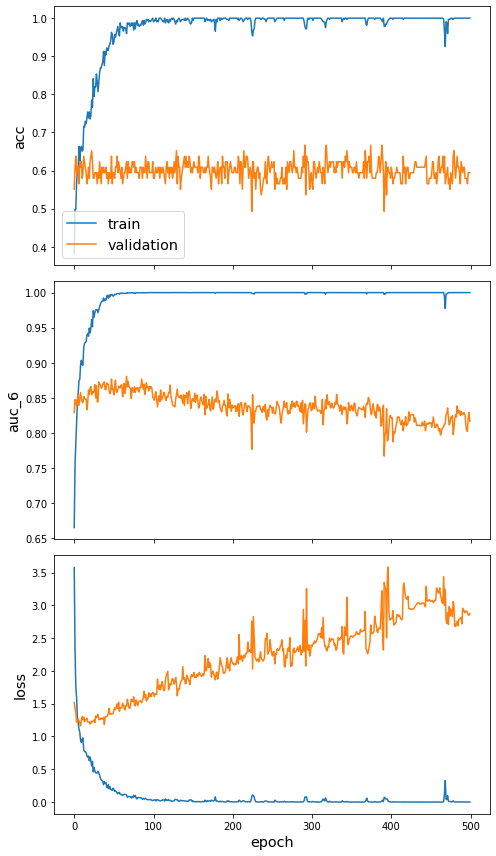

In [195]:
sg.utils.plot_history(history)

In [197]:
X_test = df_features.loc[test_subjects.index].values
y_test = test_targets

test_metrics = model.evaluate(X_test, y_test)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 0s 2ms/step - loss: 3.5845 - acc: 0.5857 - auc_6: 0.8037

Test Set Metrics:
	loss: 3.5845
	acc: 0.5857
	auc_6: 0.8037


In [164]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64, float32
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_true = cast(y_true, dtype=float32)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [176]:
gat = GAT(
    layer_sizes=[100, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.1,
    attn_dropout=0.1,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [178]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
    loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(np.array([1,1,1,1,1])),#weights/(max(weights)+1)),#weights),#weights/(max(weights)+1)),
    metrics=["acc", metrics.AUC(curve="ROC")],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [180]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=500#200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [181]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 3s - loss: 8.3636 - acc: 0.1153 - auc: 0.3898 - val_loss: 6.2971 - val_acc: 0.0580 - val_auc: 0.3526
Epoch 2/500
1/1 - 0s - loss: 6.3587 - acc: 0.1838 - auc: 0.4471 - val_loss: 3.9461 - val_acc: 0.1884 - val_auc: 0.4923
Epoch 3/500
1/1 - 0s - loss: 4.4783 - acc: 0.3053 - auc: 0.5856 - val_loss: 3.0697 - val_acc: 0.4348 - val_auc: 0.6742
Epoch 4/500
1/1 - 0s - loss: 5.1098 - acc: 0.3364 - auc: 0.6203 - val_loss: 3.7085 - val_acc: 0.4638 - val_auc: 0.6629
Epoch 5/500
1/1 - 0s - loss: 4.8711 - acc: 0.3520 - auc: 0.6333 - val_loss: 3.8171 - val_acc: 0.4203 - val_auc: 0.6766
Epoch 6/500
1/1 - 0s - loss: 5.2792 - acc: 0.3832 - auc: 0.6483 - val_loss: 3.3705 - val_acc: 0.4348 - val_auc: 0.7541
Epoch 7/500
1/1 - 0s - loss: 5.5744 - acc: 0.3614 - auc: 0.6577 - val_loss: 2.8688 - val_acc: 0.6087 - val_auc: 0.7516
Epoch 8/500
1/1 - 0s - loss: 3.9481 - acc: 0.4922 - auc: 0.7264 - val_loss: 2.7491 - val_acc: 0.6087 - val_auc: 0.7540
Epoch 9/500
1/1 - 0s - loss: 3.9751 - acc: 0.489

Epoch 70/500
1/1 - 0s - loss: 2.1327 - acc: 0.5701 - auc: 0.8027 - val_loss: 2.2369 - val_acc: 0.5072 - val_auc: 0.7487
Epoch 71/500
1/1 - 0s - loss: 2.1313 - acc: 0.5732 - auc: 0.8114 - val_loss: 2.3203 - val_acc: 0.4638 - val_auc: 0.7350
Epoch 72/500
1/1 - 0s - loss: 2.4130 - acc: 0.5670 - auc: 0.8019 - val_loss: 2.4756 - val_acc: 0.4203 - val_auc: 0.7121
Epoch 73/500
1/1 - 0s - loss: 2.4554 - acc: 0.5016 - auc: 0.7825 - val_loss: 2.4619 - val_acc: 0.4203 - val_auc: 0.7168
Epoch 74/500
1/1 - 0s - loss: 2.4753 - acc: 0.5078 - auc: 0.7742 - val_loss: 2.4369 - val_acc: 0.4203 - val_auc: 0.7331
Epoch 75/500
1/1 - 0s - loss: 2.1968 - acc: 0.5639 - auc: 0.7977 - val_loss: 2.3243 - val_acc: 0.4783 - val_auc: 0.7528
Epoch 76/500
1/1 - 0s - loss: 2.5105 - acc: 0.5358 - auc: 0.8005 - val_loss: 2.1602 - val_acc: 0.5362 - val_auc: 0.7799
Epoch 77/500
1/1 - 0s - loss: 2.7019 - acc: 0.5857 - auc: 0.8012 - val_loss: 2.0921 - val_acc: 0.5507 - val_auc: 0.7847
Epoch 78/500
1/1 - 0s - loss: 1.8559 - a

Epoch 138/500
1/1 - 0s - loss: 1.7838 - acc: 0.5888 - auc: 0.8334 - val_loss: 2.2611 - val_acc: 0.4203 - val_auc: 0.7829
Epoch 139/500
1/1 - 0s - loss: 1.8039 - acc: 0.5171 - auc: 0.8196 - val_loss: 2.3379 - val_acc: 0.4058 - val_auc: 0.7756
Epoch 140/500
1/1 - 0s - loss: 1.9463 - acc: 0.5171 - auc: 0.8048 - val_loss: 2.0833 - val_acc: 0.4638 - val_auc: 0.7821
Epoch 141/500
1/1 - 0s - loss: 1.7965 - acc: 0.5763 - auc: 0.8436 - val_loss: 1.7326 - val_acc: 0.5362 - val_auc: 0.8122
Epoch 142/500
1/1 - 0s - loss: 1.8396 - acc: 0.5981 - auc: 0.8436 - val_loss: 1.5293 - val_acc: 0.6667 - val_auc: 0.8292
Epoch 143/500
1/1 - 0s - loss: 1.7630 - acc: 0.6168 - auc: 0.8531 - val_loss: 1.4668 - val_acc: 0.6522 - val_auc: 0.8372
Epoch 144/500
1/1 - 0s - loss: 1.8592 - acc: 0.6168 - auc: 0.8347 - val_loss: 1.4531 - val_acc: 0.6377 - val_auc: 0.8394
Epoch 145/500
1/1 - 0s - loss: 2.2331 - acc: 0.6106 - auc: 0.8225 - val_loss: 1.4538 - val_acc: 0.6377 - val_auc: 0.8360
Epoch 146/500
1/1 - 0s - loss: 1

Epoch 206/500
1/1 - 0s - loss: 1.6016 - acc: 0.5639 - auc: 0.8292 - val_loss: 1.7743 - val_acc: 0.5072 - val_auc: 0.8102
Epoch 207/500
1/1 - 0s - loss: 1.4493 - acc: 0.5981 - auc: 0.8634 - val_loss: 1.6054 - val_acc: 0.5652 - val_auc: 0.8193
Epoch 208/500
1/1 - 0s - loss: 1.8987 - acc: 0.5452 - auc: 0.8205 - val_loss: 1.5055 - val_acc: 0.5652 - val_auc: 0.8389
Epoch 209/500
1/1 - 0s - loss: 1.4359 - acc: 0.6293 - auc: 0.8694 - val_loss: 1.4858 - val_acc: 0.5942 - val_auc: 0.8438
Epoch 210/500
1/1 - 0s - loss: 1.4434 - acc: 0.6417 - auc: 0.8682 - val_loss: 1.4911 - val_acc: 0.5942 - val_auc: 0.8462
Epoch 211/500
1/1 - 0s - loss: 1.6279 - acc: 0.5576 - auc: 0.8515 - val_loss: 1.4988 - val_acc: 0.6232 - val_auc: 0.8415
Epoch 212/500
1/1 - 0s - loss: 1.7961 - acc: 0.5296 - auc: 0.8209 - val_loss: 1.5566 - val_acc: 0.6232 - val_auc: 0.8403
Epoch 213/500
1/1 - 0s - loss: 1.7012 - acc: 0.6044 - auc: 0.8434 - val_loss: 1.6692 - val_acc: 0.5217 - val_auc: 0.8277
Epoch 214/500
1/1 - 0s - loss: 1

Epoch 274/500
1/1 - 0s - loss: 1.4174 - acc: 0.6449 - auc: 0.8757 - val_loss: 1.3931 - val_acc: 0.6812 - val_auc: 0.8558
Epoch 275/500
1/1 - 0s - loss: 1.2722 - acc: 0.6822 - auc: 0.8856 - val_loss: 1.4508 - val_acc: 0.6377 - val_auc: 0.8422
Epoch 276/500
1/1 - 0s - loss: 1.1795 - acc: 0.6636 - auc: 0.8927 - val_loss: 1.5585 - val_acc: 0.4928 - val_auc: 0.8294
Epoch 277/500
1/1 - 0s - loss: 1.2162 - acc: 0.5670 - auc: 0.8740 - val_loss: 1.5323 - val_acc: 0.4928 - val_auc: 0.8304
Epoch 278/500
1/1 - 0s - loss: 1.3442 - acc: 0.6075 - auc: 0.8678 - val_loss: 1.4754 - val_acc: 0.5072 - val_auc: 0.8395
Epoch 279/500
1/1 - 0s - loss: 1.3500 - acc: 0.6480 - auc: 0.8652 - val_loss: 1.4366 - val_acc: 0.5362 - val_auc: 0.8441
Epoch 280/500
1/1 - 0s - loss: 1.3553 - acc: 0.6511 - auc: 0.8619 - val_loss: 1.4240 - val_acc: 0.5797 - val_auc: 0.8474
Epoch 281/500
1/1 - 0s - loss: 1.2957 - acc: 0.6199 - auc: 0.8744 - val_loss: 1.4007 - val_acc: 0.6522 - val_auc: 0.8532
Epoch 282/500
1/1 - 0s - loss: 1

Epoch 342/500
1/1 - 0s - loss: 1.1195 - acc: 0.6636 - auc: 0.8978 - val_loss: 1.2785 - val_acc: 0.6522 - val_auc: 0.8737
Epoch 343/500
1/1 - 0s - loss: 1.1601 - acc: 0.6386 - auc: 0.8918 - val_loss: 1.2749 - val_acc: 0.6522 - val_auc: 0.8736
Epoch 344/500
1/1 - 0s - loss: 1.2157 - acc: 0.6480 - auc: 0.8835 - val_loss: 1.2998 - val_acc: 0.6232 - val_auc: 0.8628
Epoch 345/500
1/1 - 0s - loss: 1.0810 - acc: 0.6168 - auc: 0.8869 - val_loss: 1.3299 - val_acc: 0.6087 - val_auc: 0.8534
Epoch 346/500
1/1 - 0s - loss: 1.1609 - acc: 0.6760 - auc: 0.8864 - val_loss: 1.3559 - val_acc: 0.5942 - val_auc: 0.8496
Epoch 347/500
1/1 - 0s - loss: 1.3325 - acc: 0.5888 - auc: 0.8581 - val_loss: 1.3723 - val_acc: 0.5942 - val_auc: 0.8515
Epoch 348/500
1/1 - 0s - loss: 1.3157 - acc: 0.5701 - auc: 0.8487 - val_loss: 1.3441 - val_acc: 0.6377 - val_auc: 0.8606
Epoch 349/500
1/1 - 0s - loss: 1.1801 - acc: 0.6573 - auc: 0.8907 - val_loss: 1.3531 - val_acc: 0.6522 - val_auc: 0.8669
Epoch 350/500
1/1 - 0s - loss: 1

Epoch 410/500
1/1 - 0s - loss: 1.1480 - acc: 0.6542 - auc: 0.8846 - val_loss: 1.5816 - val_acc: 0.4638 - val_auc: 0.8170
Epoch 411/500
1/1 - 0s - loss: 1.2649 - acc: 0.6012 - auc: 0.8654 - val_loss: 1.4594 - val_acc: 0.5362 - val_auc: 0.8338
Epoch 412/500
1/1 - 0s - loss: 1.0782 - acc: 0.6480 - auc: 0.8951 - val_loss: 1.2999 - val_acc: 0.6232 - val_auc: 0.8546
Epoch 413/500
1/1 - 0s - loss: 1.0627 - acc: 0.6822 - auc: 0.8967 - val_loss: 1.1801 - val_acc: 0.6522 - val_auc: 0.8728
Epoch 414/500
1/1 - 0s - loss: 1.0817 - acc: 0.6698 - auc: 0.8896 - val_loss: 1.1522 - val_acc: 0.6812 - val_auc: 0.8910
Epoch 415/500
1/1 - 0s - loss: 1.3955 - acc: 0.7040 - auc: 0.8769 - val_loss: 1.1287 - val_acc: 0.6812 - val_auc: 0.8887
Epoch 416/500
1/1 - 0s - loss: 1.1446 - acc: 0.6854 - auc: 0.8897 - val_loss: 1.1103 - val_acc: 0.6667 - val_auc: 0.8818
Epoch 417/500
1/1 - 0s - loss: 1.1416 - acc: 0.6947 - auc: 0.8875 - val_loss: 1.1263 - val_acc: 0.6522 - val_auc: 0.8746
Epoch 418/500
1/1 - 0s - loss: 1

Epoch 478/500
1/1 - 0s - loss: 1.2121 - acc: 0.6262 - auc: 0.8777 - val_loss: 1.2961 - val_acc: 0.6667 - val_auc: 0.8572
Epoch 479/500
1/1 - 0s - loss: 1.0100 - acc: 0.6854 - auc: 0.8884 - val_loss: 1.2581 - val_acc: 0.6812 - val_auc: 0.8628
Epoch 480/500
1/1 - 0s - loss: 0.8902 - acc: 0.6885 - auc: 0.9120 - val_loss: 1.2395 - val_acc: 0.6667 - val_auc: 0.8689
Epoch 481/500
1/1 - 0s - loss: 1.0813 - acc: 0.6698 - auc: 0.8862 - val_loss: 1.2541 - val_acc: 0.6522 - val_auc: 0.8689
Epoch 482/500
1/1 - 0s - loss: 1.0213 - acc: 0.6885 - auc: 0.8974 - val_loss: 1.2921 - val_acc: 0.6232 - val_auc: 0.8662
Epoch 483/500
1/1 - 0s - loss: 0.9940 - acc: 0.6449 - auc: 0.8974 - val_loss: 1.2982 - val_acc: 0.6232 - val_auc: 0.8658
Epoch 484/500
1/1 - 0s - loss: 1.1147 - acc: 0.7040 - auc: 0.8981 - val_loss: 1.2977 - val_acc: 0.6232 - val_auc: 0.8650
Epoch 485/500
1/1 - 0s - loss: 0.9625 - acc: 0.6573 - auc: 0.9013 - val_loss: 1.2813 - val_acc: 0.6232 - val_auc: 0.8647
Epoch 486/500
1/1 - 0s - loss: 0

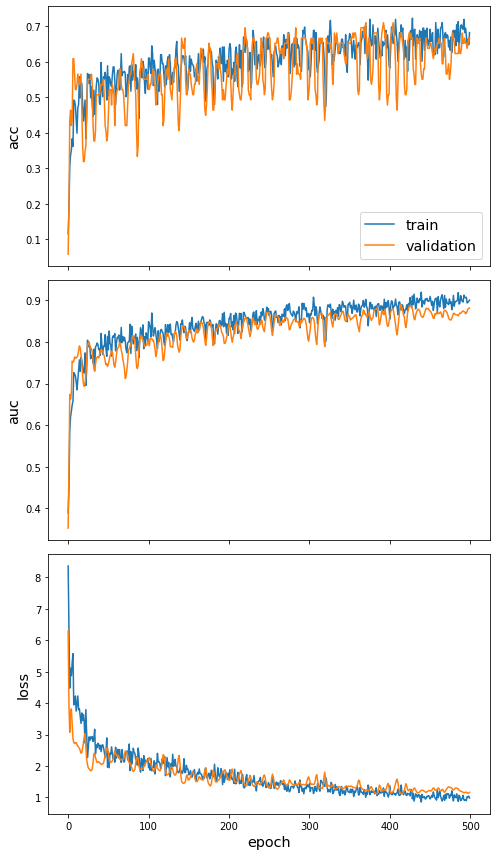

In [182]:
sg.utils.plot_history(history)

In [183]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 40ms/step - loss: 1.3358 - acc: 0.6143 - auc: 0.8438

Test Set Metrics:
	loss: 1.3358
	acc: 0.6143
	auc: 0.8438


In [184]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [185]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})

print(df['True'].value_counts(), "\n")
df['Predicted'].value_counts()

stage1     219
stage3      78
control     72
stage4      54
stage2      37
Name: True, dtype: int64 



stage1     250
control     74
stage4      70
stage3      59
stage2       7
Name: Predicted, dtype: int64

In [126]:
for component in G.connected_components():
    print(len(component))

430
15
6
3
2
2
2


In [127]:
G.node_degrees()

defaultdict(int,
            {'TCGA.CJ.5672.11': 72,
             'TCGA.CJ.5678.11': 55,
             'TCGA.B0.5712.11': 46,
             'TCGA.CZ.5458.11': 33,
             'TCGA.CW.5580.11': 71,
             'TCGA.CZ.5463.11': 71,
             'TCGA.CZ.5469.11': 32,
             'TCGA.CZ.4864.11': 52,
             'TCGA.B8.5549.11': 33,
             'TCGA.B0.5701.11': 70,
             'TCGA.CW.5581.11': 53,
             'TCGA.CZ.5455.11': 31,
             'TCGA.B0.5709.11': 53,
             'TCGA.CZ.5470.11': 40,
             'TCGA.CJ.5676.11': 54,
             'TCGA.CZ.5468.11': 45,
             'TCGA.CZ.5982.11': 49,
             'TCGA.CZ.5461.11': 70,
             'TCGA.CZ.5989.11': 36,
             'TCGA.CJ.6030.11': 54,
             'TCGA.CZ.5456.11': 30,
             'TCGA.CJ.5680.11': 52,
             'TCGA.B8.4622.11': 52,
             'TCGA.CW.6087.11': 67,
             'TCGA.B0.5694.11': 58,
             'TCGA.CZ.5466.11': 54,
             'TCGA.CJ.5679.11': 61,
           

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

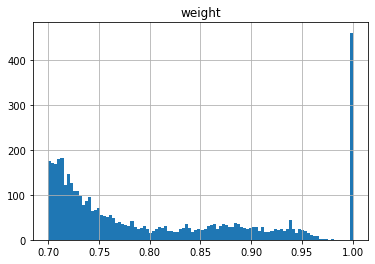

In [128]:
df_patients.hist(column='weight', bins=100)